# Application of aged hematopoiesis dataset

In [1]:
import torch.nn as nn
import scFocus
import scanpy as sc
import pandas as pd
import numpy as np
import joblib
import torch
import matplotlib.pyplot as plt
import seaborn as sns


In [37]:
cm = 1/2.54
sc.set_figure_params(figsize=(5*cm,5*cm),dpi=300,fontsize=10,frameon=False)

In [6]:
adata = sc.read_10x_mtx('../Downloads/GSE255019/', prefix='GSE255019_')

In [10]:
meta = pd.read_csv('../Downloads/GSE255019/GSE255019_meta_aging_final_annotation.csv.gz', header=0,index_col=0)

In [14]:
adata = adata[meta.index,:]

In [15]:
adata.obs = meta

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata, use_highly_variable=True)

C:\Users\11196\miniconda3\envs\blood\lib\site-packages\scanpy\preprocessing\_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [24]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

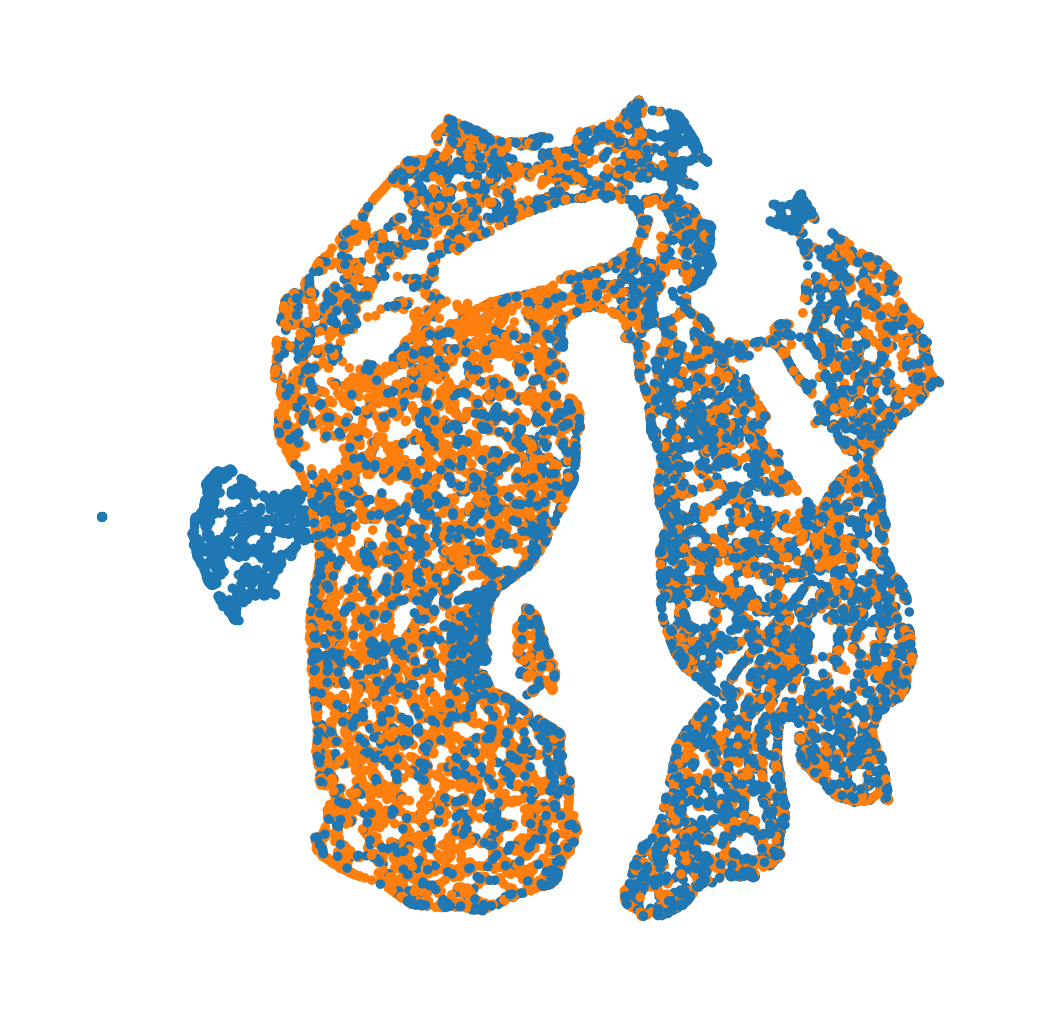

In [72]:
sc.pl.umap(adata, color='Age',title='',legend_loc=None)

In [26]:
umap = adata.obsm['X_umap']

In [91]:
umap = adata.obsm['X_umap']

pd.DataFrame(umap).to_csv('Hemato.csv')

In [57]:
focus = scFocus.focus(umap, n=6, max_steps=3, pct_samples=.01).meta_focusing(5)

Meta fitting... 7: 100%|████████████████████████████████████| 100/100 [00:12<00:00,  8.10it/s, E=700, R=-5.89, S=18.96]


Converged at iteration 7. Training stopped!
Meta fitting time used: 91.21 seconds


Focus fitting...: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.96it/s]


Focus fitting time used: 1.27 seconds


Meta fitting... 7: 100%|████████████████████████████████████| 100/100 [00:12<00:00,  8.25it/s, E=700, R=-6.71, S=18.99]


Converged at iteration 7. Training stopped!
Meta fitting time used: 83.42 seconds


Focus fitting...: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.90it/s]


Focus fitting time used: 1.28 seconds


Meta fitting... 7: 100%|████████████████████████████████████| 100/100 [00:14<00:00,  6.97it/s, E=700, R=-6.76, S=18.93]


Converged at iteration 7. Training stopped!
Meta fitting time used: 85.51 seconds


Focus fitting...: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.87it/s]


Focus fitting time used: 1.48 seconds


Meta fitting... 7: 100%|████████████████████████████████████| 100/100 [00:14<00:00,  6.77it/s, E=700, R=-6.04, S=18.95]


Converged at iteration 7. Training stopped!
Meta fitting time used: 93.69 seconds


Focus fitting...: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.14it/s]


Focus fitting time used: 1.65 seconds


Meta fitting... 7: 100%|████████████████████████████████████| 100/100 [00:25<00:00,  3.99it/s, E=700, R=-7.47, S=19.20]


Converged at iteration 7. Training stopped!
Meta fitting time used: 115.95 seconds


Focus fitting...: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]

Focus fitting time used: 2.78 seconds
Meta focusing time used: 478.28 seconds


In [58]:
focus.merge_fp2()

mfp = focus.mfp[0]

for i in range(mfp.shape[1]):
    
    adata.obs[f'f{i}'] = mfp[:, i]

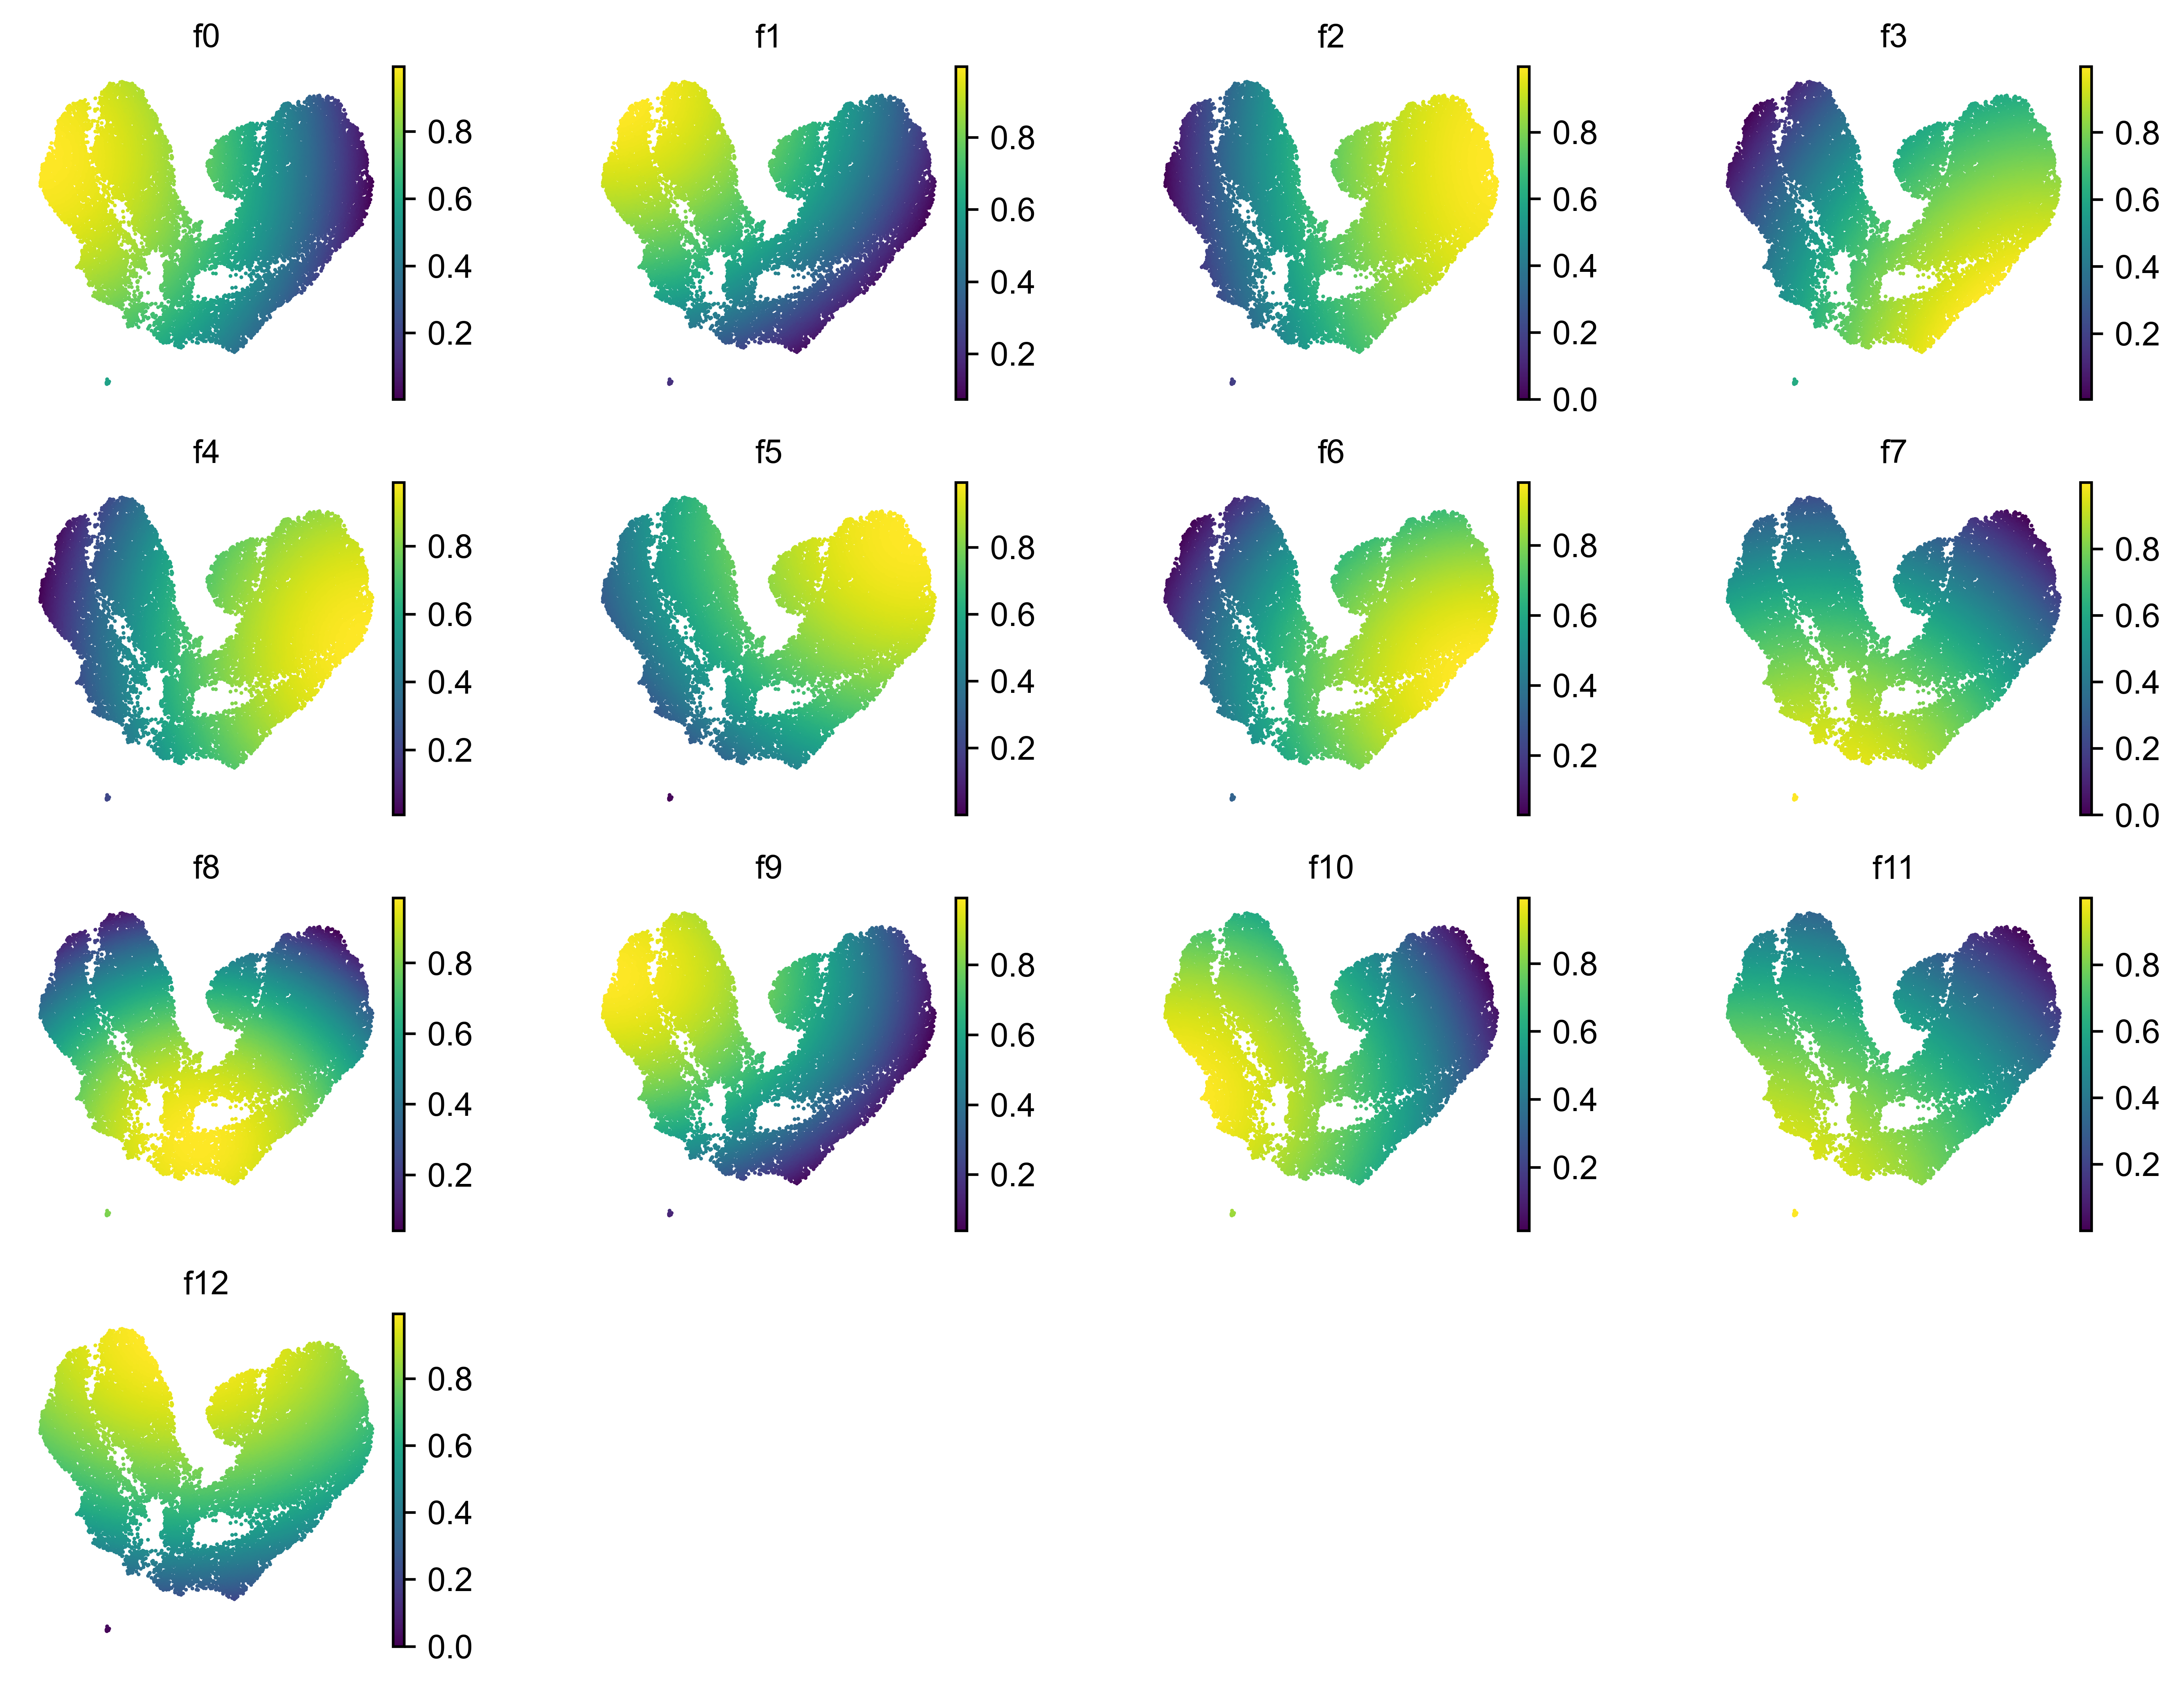

In [59]:
sc.pl.umap(adata, color=[f'f{i}' for i in range(mfp.shape[1])], cmap='viridis')

C:\Users\11196\AppData\Local\Temp\ipykernel_33804\642893351.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=np.arange(2),x=np.unique(adata.obs['Age'], return_counts=True)[1],orient='horizonal',palette=[lut[c] for c in batches],zorder=0)
C:\Users\11196\AppData\Local\Temp\ipykernel_33804\642893351.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(batches, fontdict={'ha':'left'},zorder=10)


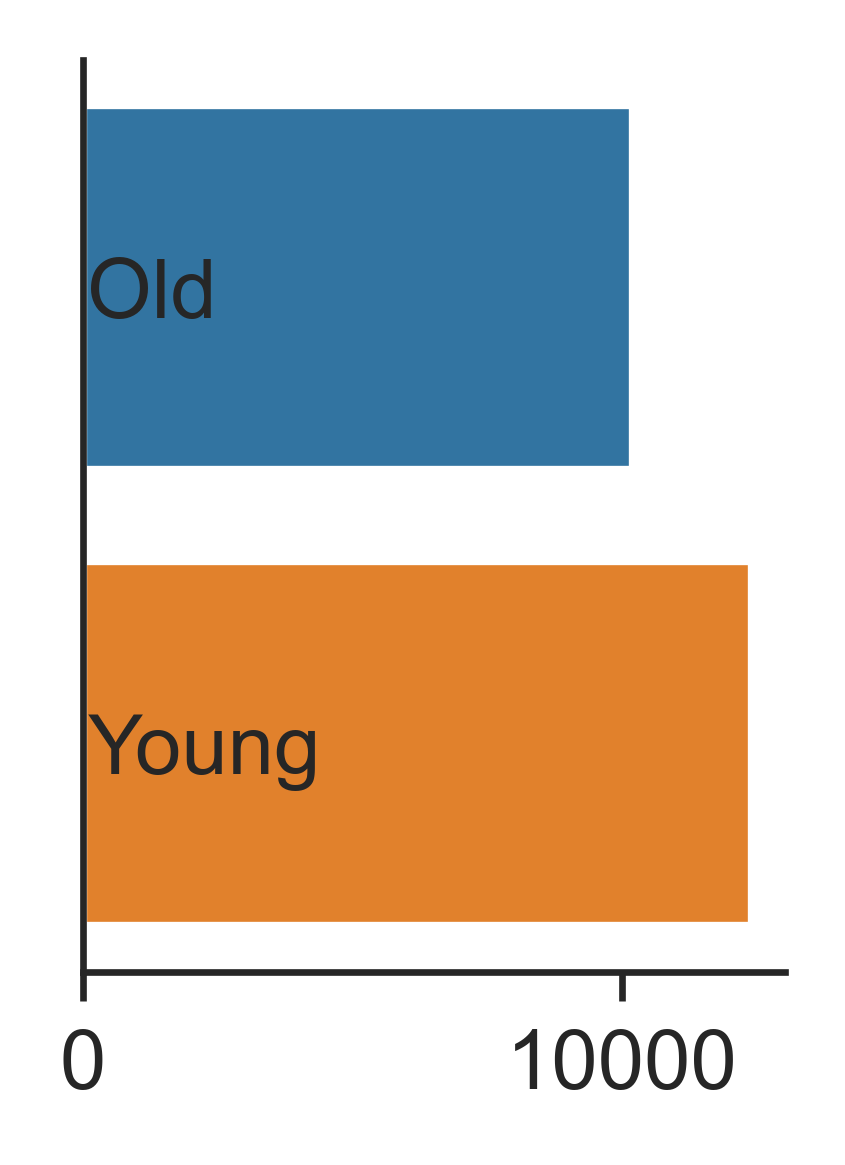

In [52]:
batches = adata.obs['Age'].cat.categories

lut = dict(zip(batches, adata.uns['Age_colors']))

with sns.axes_style('ticks'):
    fig = plt.figure(figsize=(1.5,2))
    sns.barplot(y=np.arange(2),x=np.unique(adata.obs['Age'], return_counts=True)[1],orient='horizonal',palette=[lut[c] for c in batches],zorder=0)
    ax = plt.gca()
    ax.set_yticklabels(batches, fontdict={'ha':'left'},zorder=10)
    ax.tick_params(axis='y',pad=-4,zorder=10,left=False)
    ax.spines[['right','top']].set_visible(False)

In [66]:
df = pd.DataFrame(mfp, index=adata.obs_names)

df['label'] = adata.obs['Age']

df1 = df.groupby('label').mean()

df1 = df1[np.argsort(np.argmax(df1, axis=0))]

In [61]:
from sklearn.preprocessing import StandardScaler

df1 = pd.DataFrame(StandardScaler().fit_transform(df1.values), columns=df1.columns,index=df1.index)

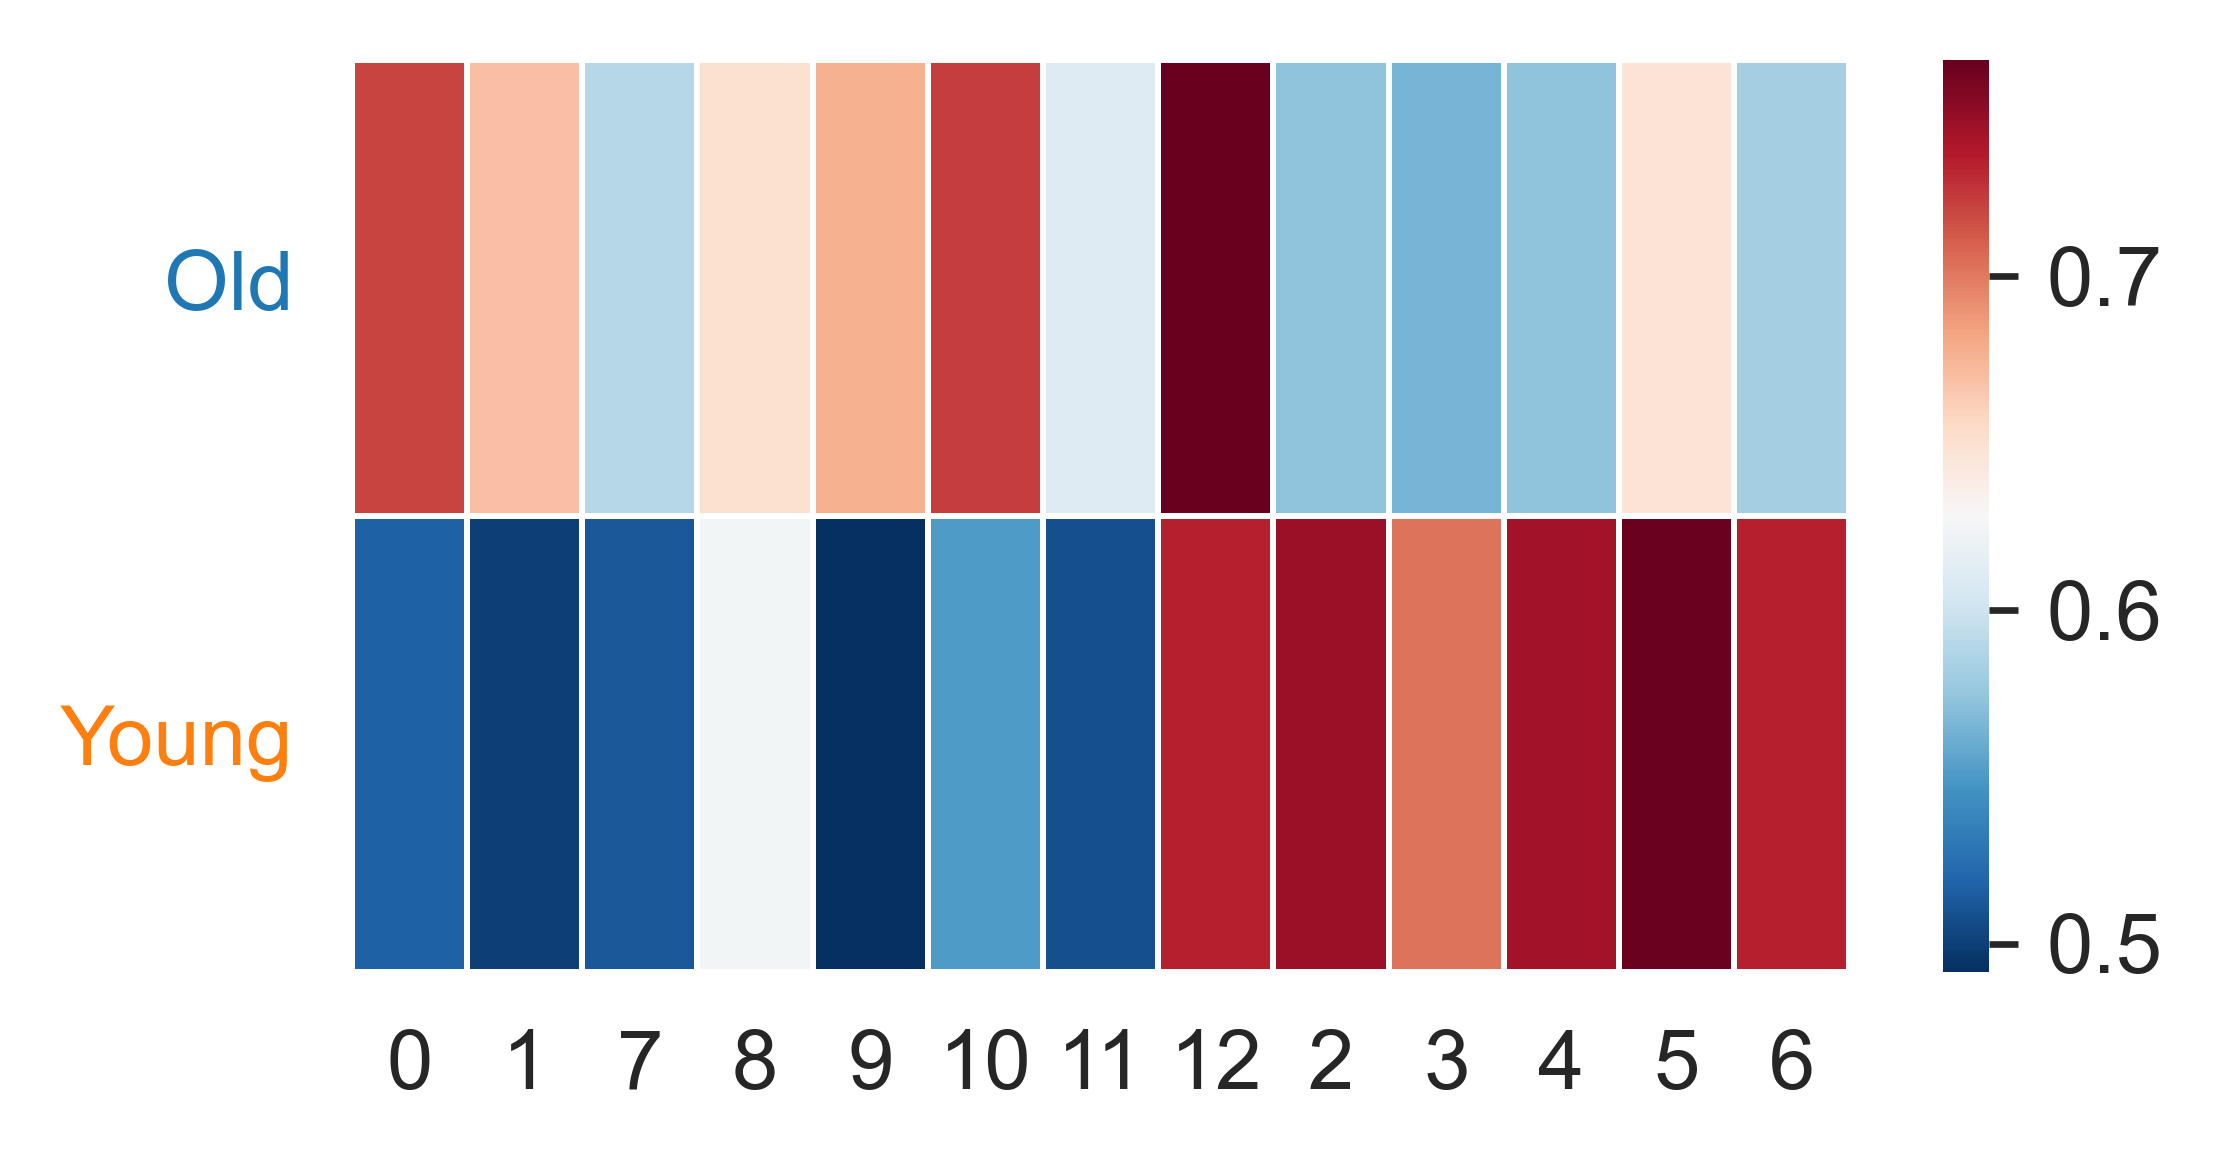

In [74]:
with sns.axes_style('white'):
    fig = plt.figure(figsize=(4,2))
    sns.heatmap(df1, xticklabels=True, lw=.5, cmap='RdBu_r')
    ax = plt.gca()

ax.set_ylabel('')
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

for tick in ax.get_yticklabels():
    tick.set_color(lut[tick.get_text()])
    tick.set_rotation(0)

In [70]:
adata.obsm['X_focus'] = adata.obs[[f'f{i}' for i in range(mfp.shape[1])]].values

sc.pp.neighbors(adata, use_rep='X_focus')

sc.tl.umap(adata, min_dist=.2)

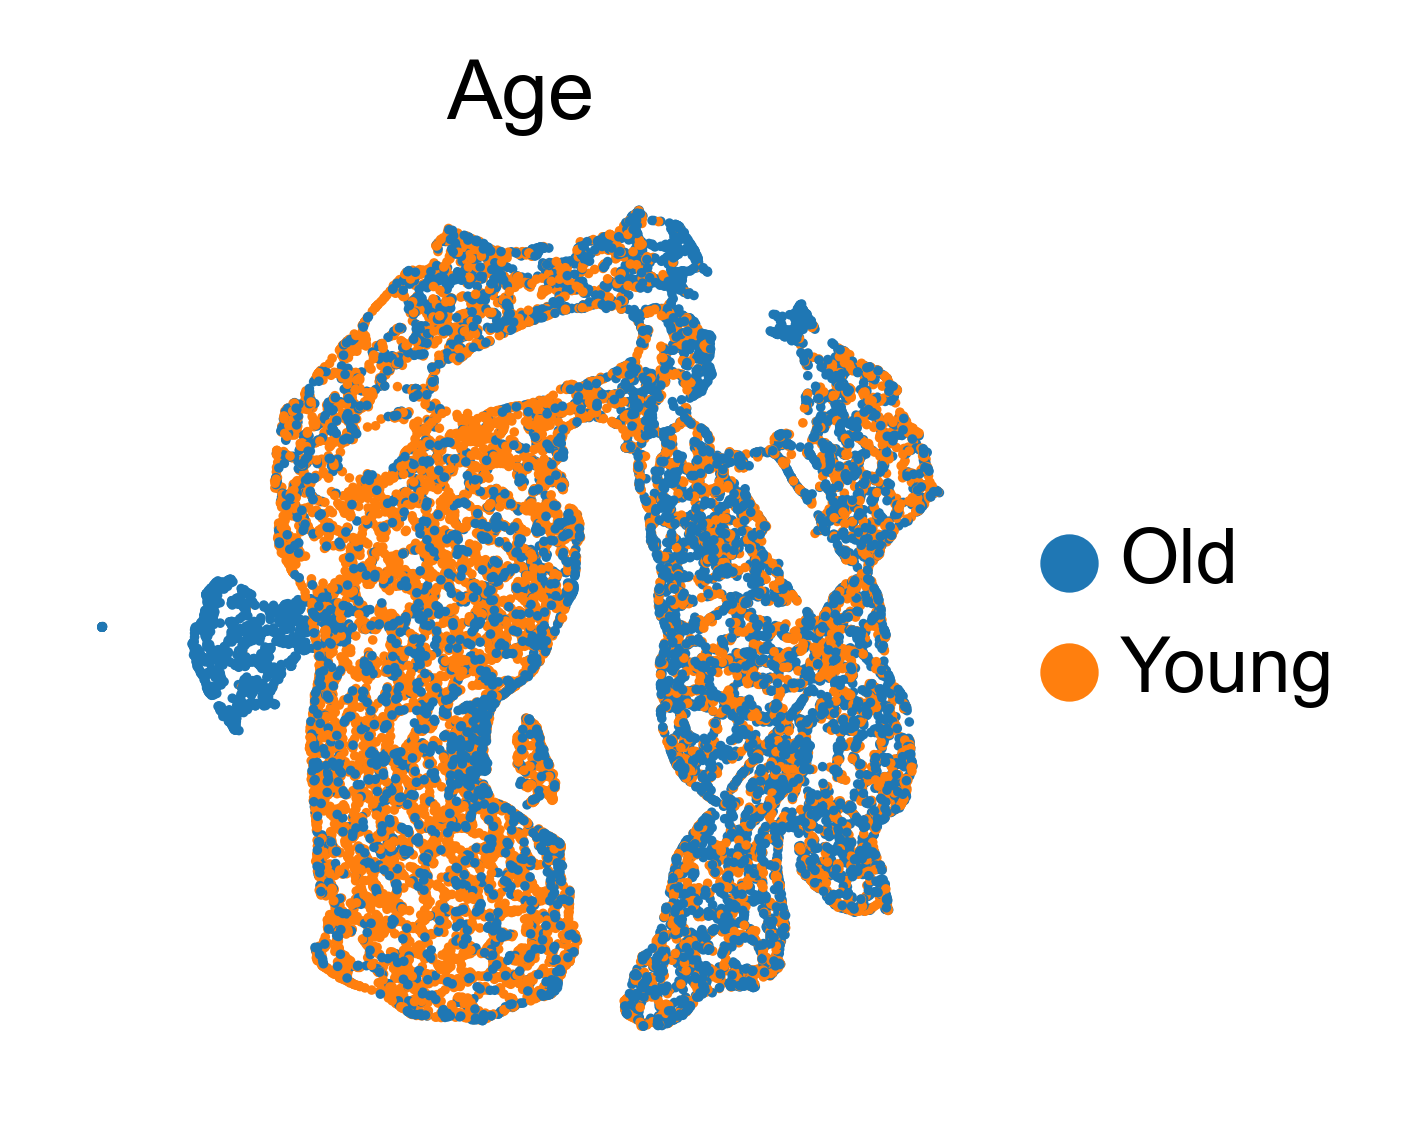

In [71]:
sc.pl.umap(adata, color='Age')

In [76]:
adata.obs['F_1'] = adata.obs[['f0','f1','f7','f8','f9','f10','f11','f12']].mean(axis=1)

adata.obs['F_2'] = adata.obs[['f5','f2','f3','f6','f4']].mean(axis=1)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

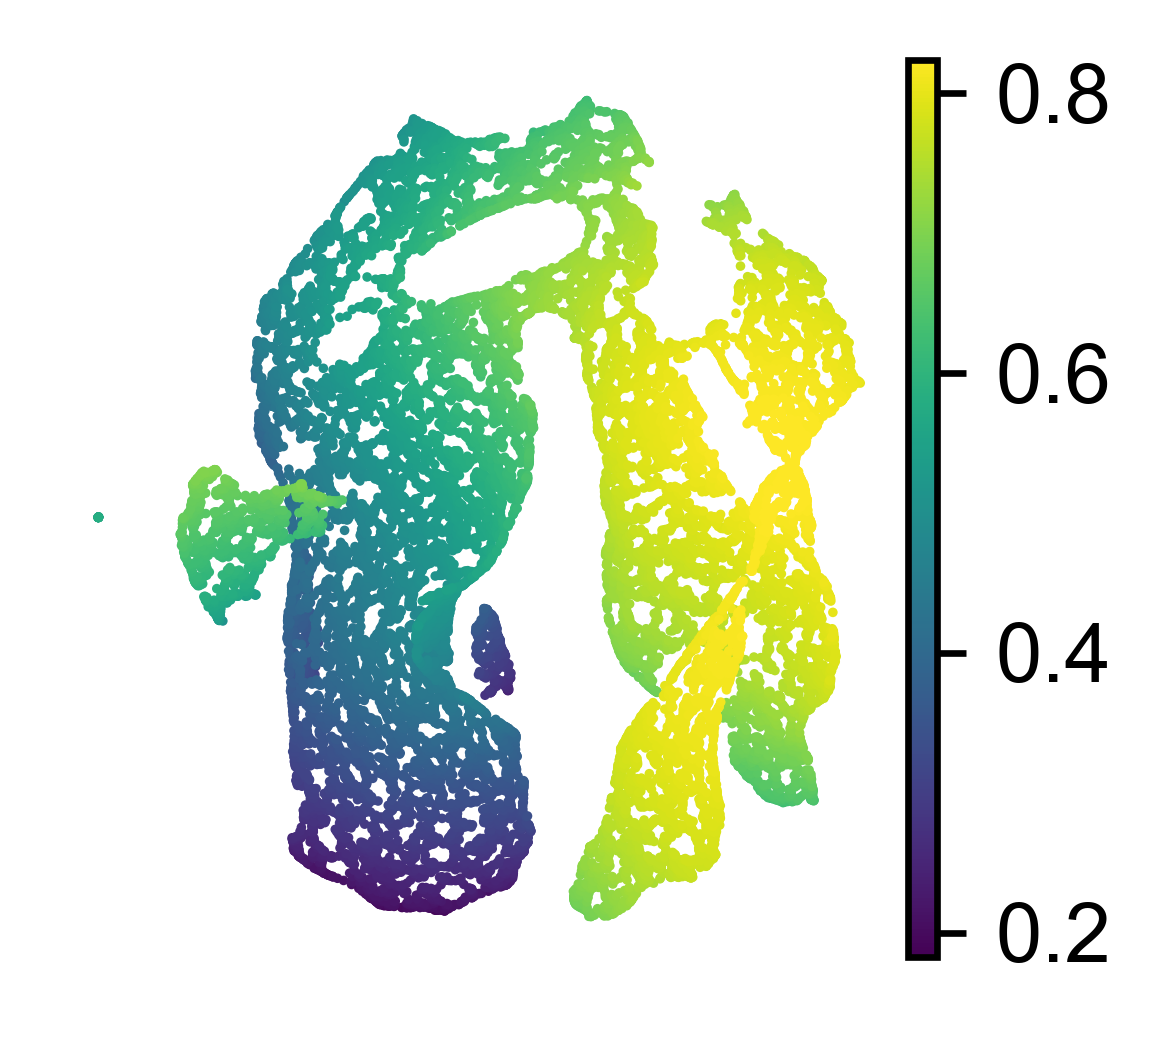

In [77]:
sc.pl.umap(adata, color='F_1', title='', show=False)


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

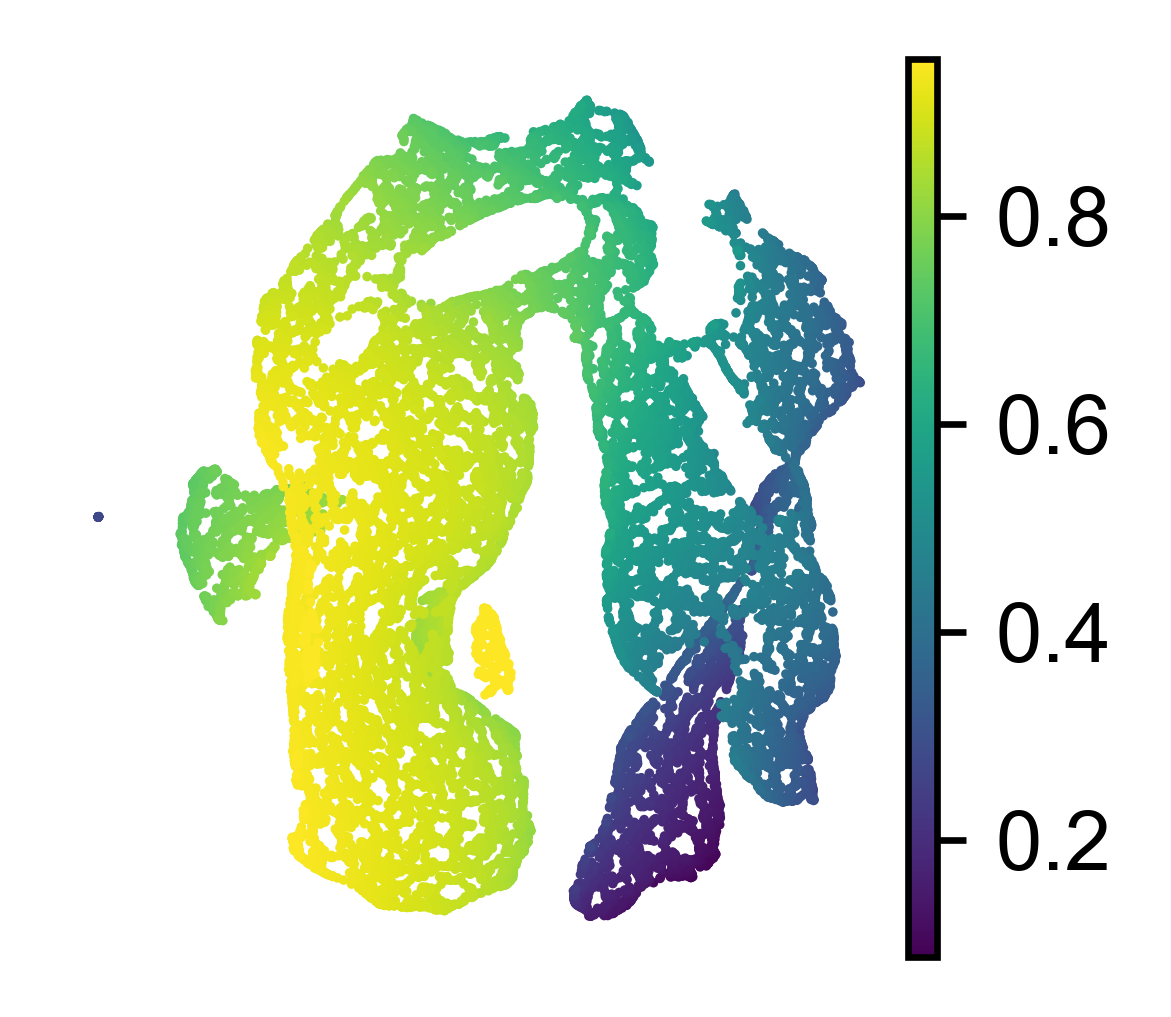

In [78]:
sc.pl.umap(adata, color='F_2', title='', show=False)


In [79]:
exp = adata[:,adata.var['highly_variable']].to_df()

exp['F_1'] = adata.obs['F_1']
exp['F_2'] = adata.obs['F_2']

corr = np.corrcoef(exp.values.T)

corr = pd.DataFrame(corr, index=exp.columns, columns=exp.columns)

In [80]:
idx1 = corr['F_1'].sort_values(ascending=False).index

idx2 = corr['F_2'].sort_values(ascending=False).index

pd.DataFrame(idx1[1:51]).to_csv('Hemato_gs1.csv')

pd.DataFrame(idx2[1:51]).to_csv('Hemato_gs2.csv')

In [81]:
idx1[:16]

Index(['F_1', 'H2afy', 'Psmb8', 'Sh3bgrl3', 'Ptpn18', 'Cmtm7', 'Arpc1b',
       'Fxyd5', 'Arhgdib', 'Coro1a', 'Gmfg', 'Pkm', 'Ramp1', 'Alox5ap',
       'Plac8', 'Tnfaip8'],
      dtype='object')

In [82]:
idx2[:16]

Index(['F_2', 'Car2', 'Blvrb', 'Car1', 'Klf1', 'Mrpl52', 'Mns1', 'Abcb4',
       'Gstm5', 'Casp3', 'Vamp5', 'Slc25a21', 'Aqp1', 'Ermap', 'Gata1',
       'Nfia'],
      dtype='object')

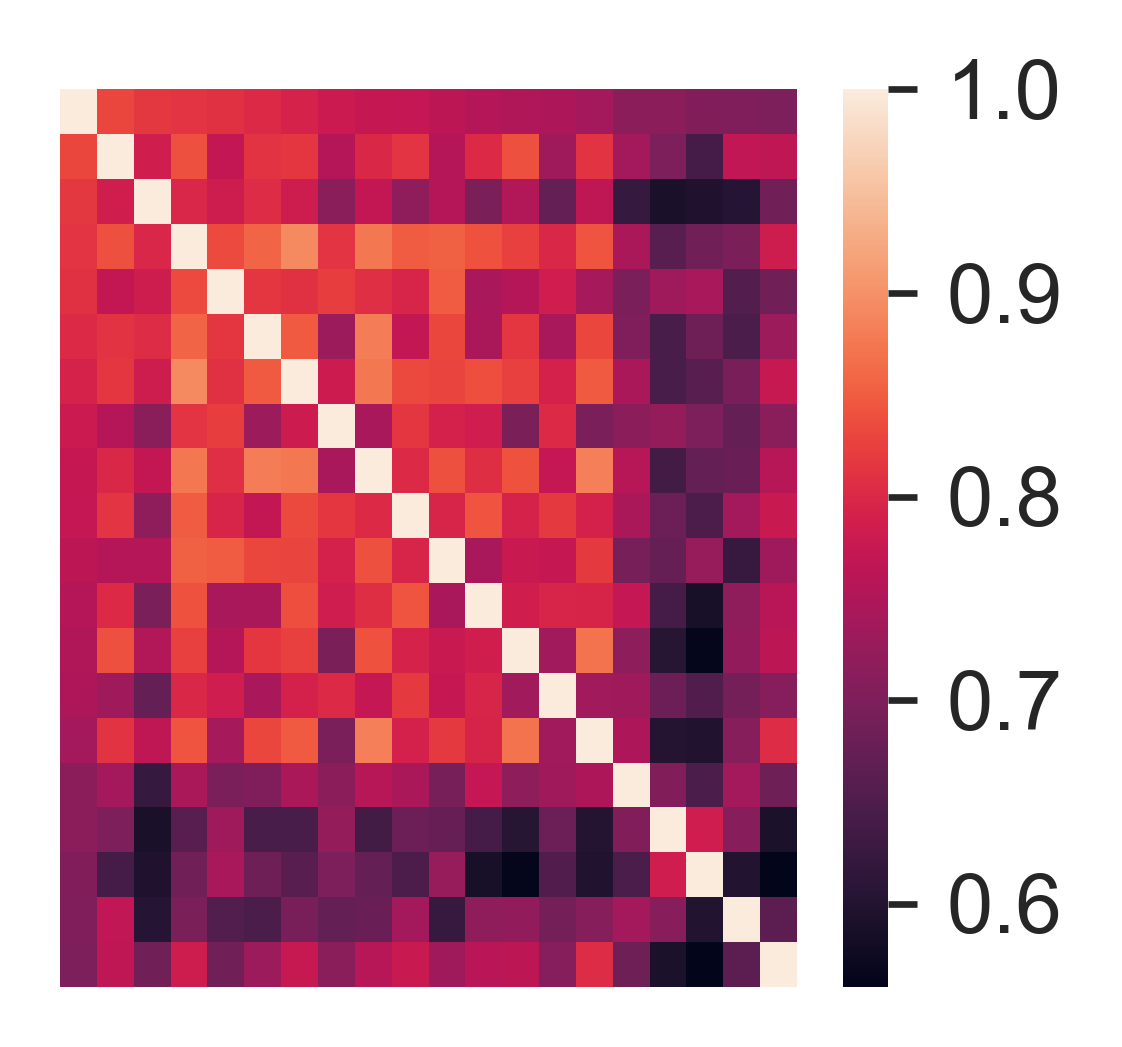

In [83]:
with sns.axes_style('white'):
    sns.heatmap(corr.loc[idx1,idx1].iloc[:20,:20])
    ax = plt.gca()
    ax.tick_params(labelleft=False,labelbottom=False)

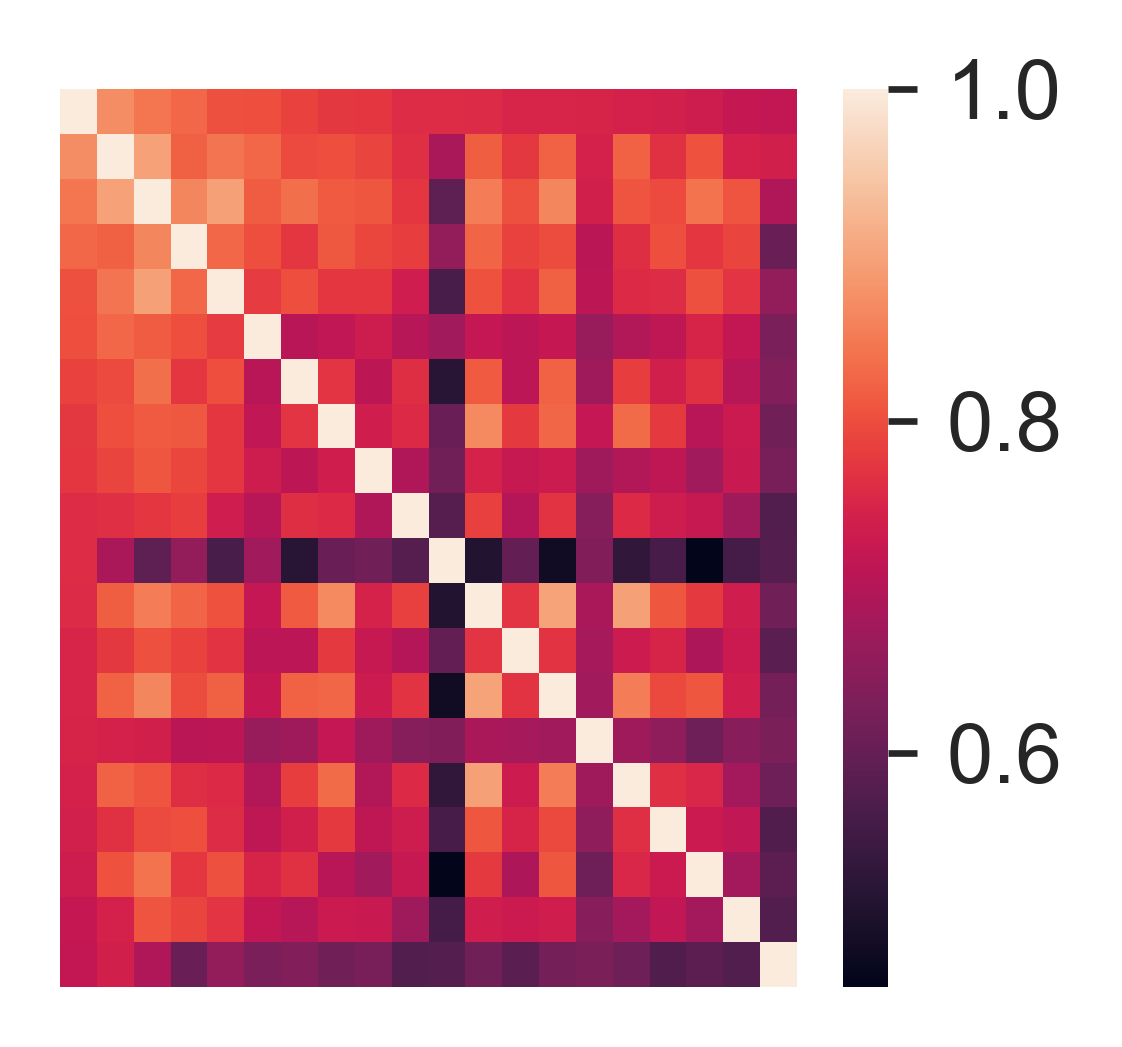

In [84]:
with sns.axes_style('white'):
    sns.heatmap(corr.loc[idx2,idx2].iloc[:20,:20])
    ax = plt.gca()
    ax.tick_params(labelleft=False,labelbottom=False)

In [85]:
adata.obs['F_1_exp'] = adata[:,['H2afy', 'Psmb8', 'Sh3bgrl3', 'Ptpn18', 'Cmtm7']].to_df().mean(axis=1)

adata.obs['F_2_exp'] = adata[:,['Car2', 'Blvrb', 'Car1', 'Klf1', 'Mrpl52']].to_df().mean(axis=1)

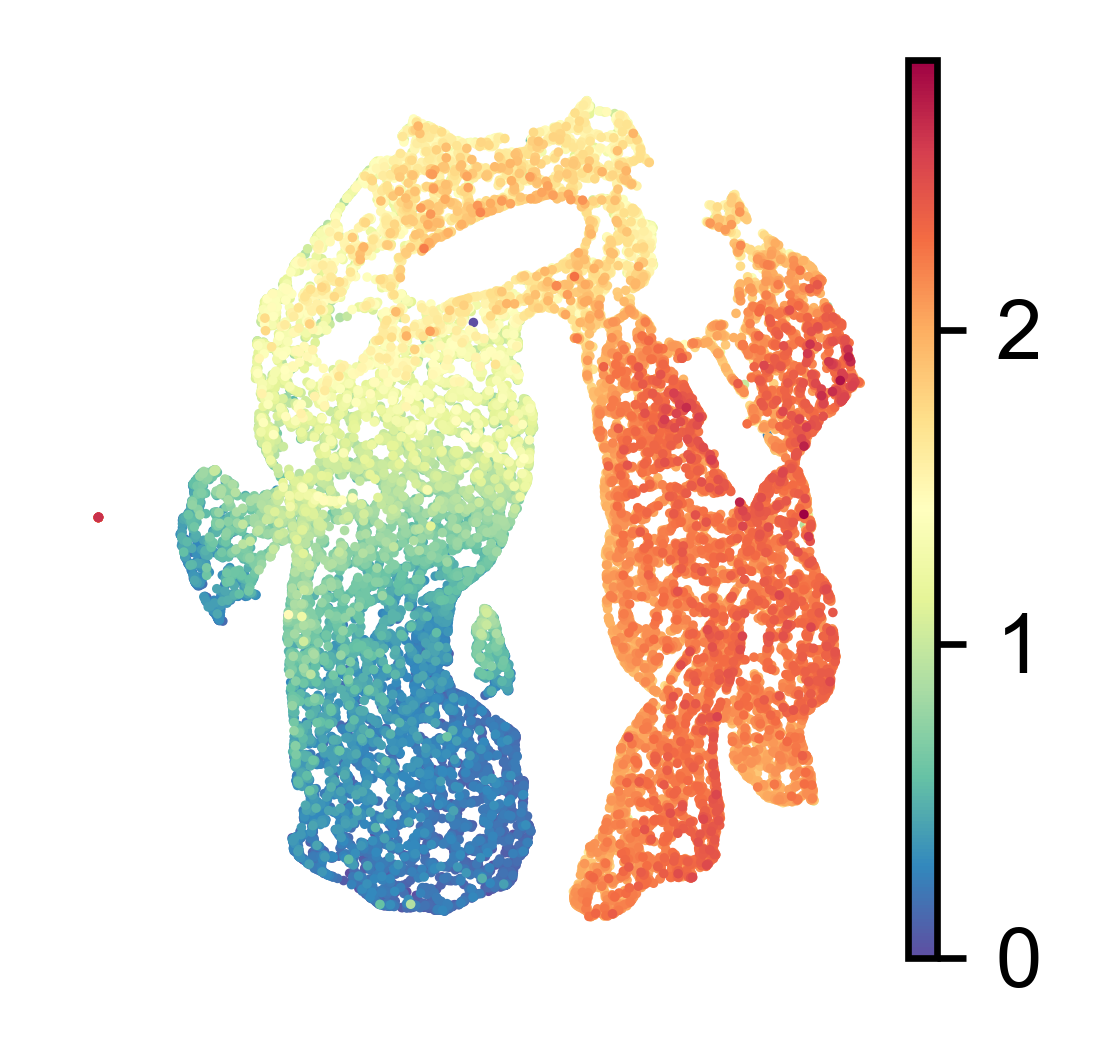

In [86]:
sc.pl.umap(adata, color='F_1_exp',title='', cmap='Spectral_r')

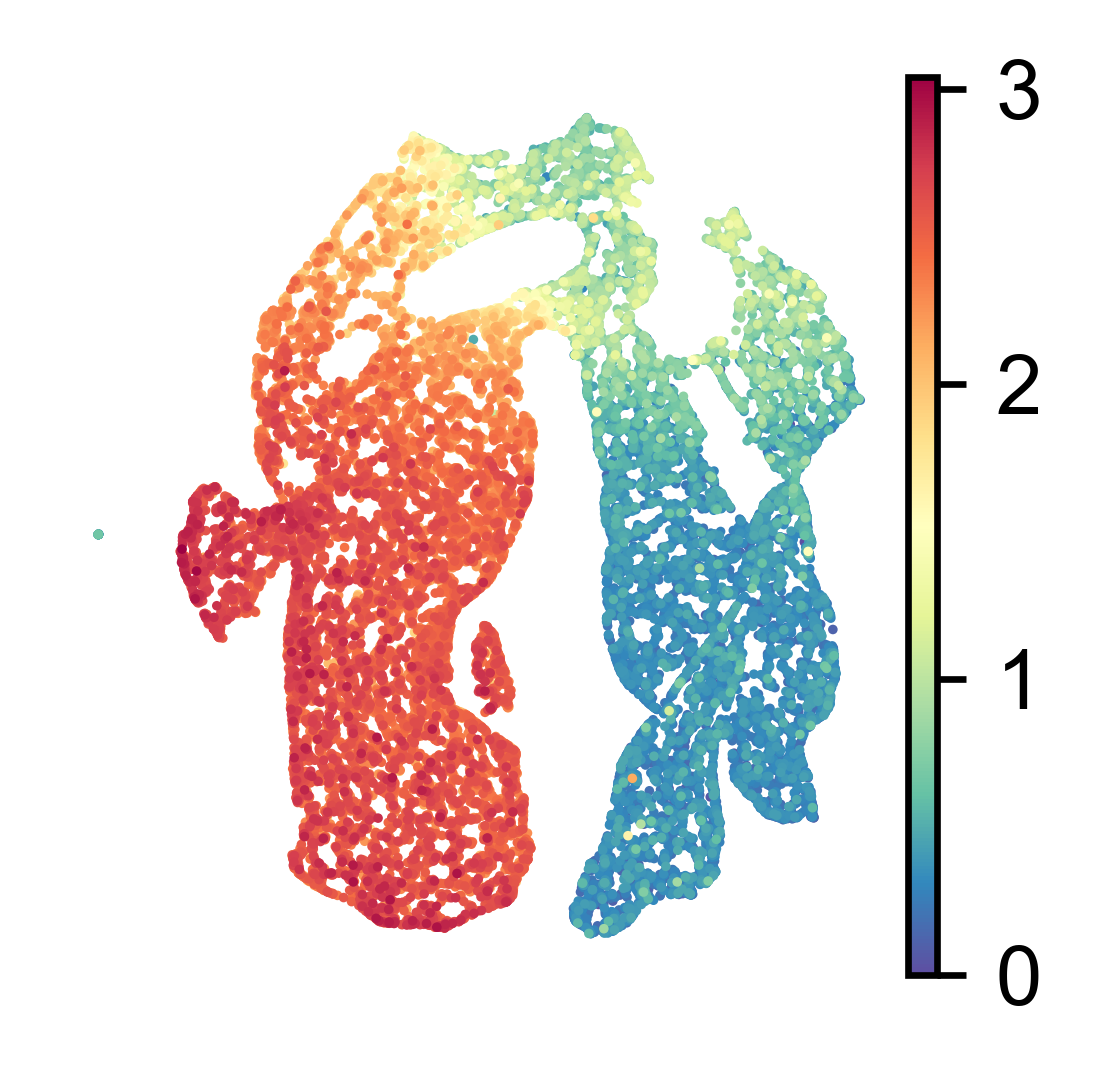

In [87]:
sc.pl.umap(adata, color='F_2_exp',title='', cmap='Spectral_r')

In [92]:
joblib.dump(adata, 'Hemato')

['Hemato']

In [93]:
joblib.dump(focus, 'Hemato_focus')

['Hemato_focus']